In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Load the data
data = pd.read_csv("Fraud_check.csv")

numerical_features = ['Taxable.Income', 'City.Population', 'Work.Experience']

categorical_columns = ['Undergrad', 'Marital.Status', 'Urban']

In [2]:
# Check for missing values
print("Missing Values:\n", data.isnull().sum())

Missing Values:
 Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64


In [3]:
data['Taxable_Income_category'] = data['Taxable.Income'].apply(lambda x: 'Risky' if x <= 30000 else 'Good')

temp_data = data.drop('Taxable.Income', axis=1)
temp_numerical_features = numerical_features
temp_numerical_features.remove('Taxable.Income')

print(temp_numerical_features)

['City.Population', 'Work.Experience']


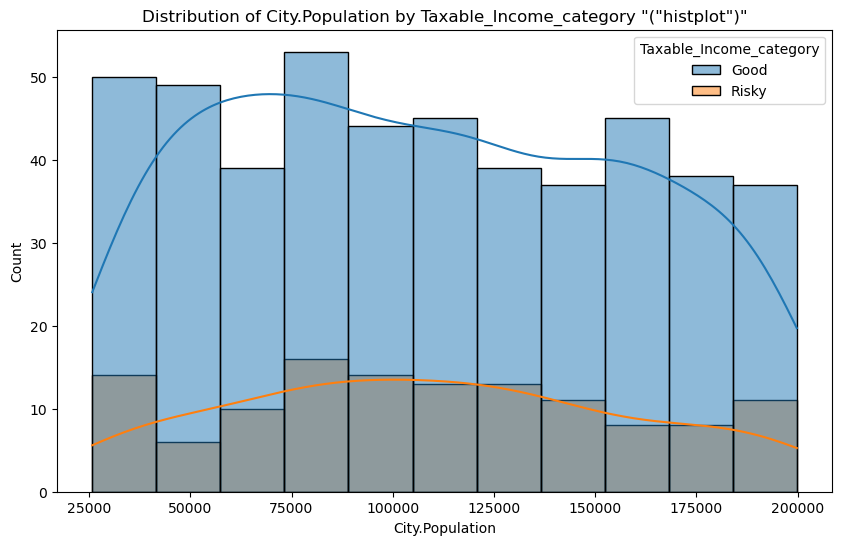

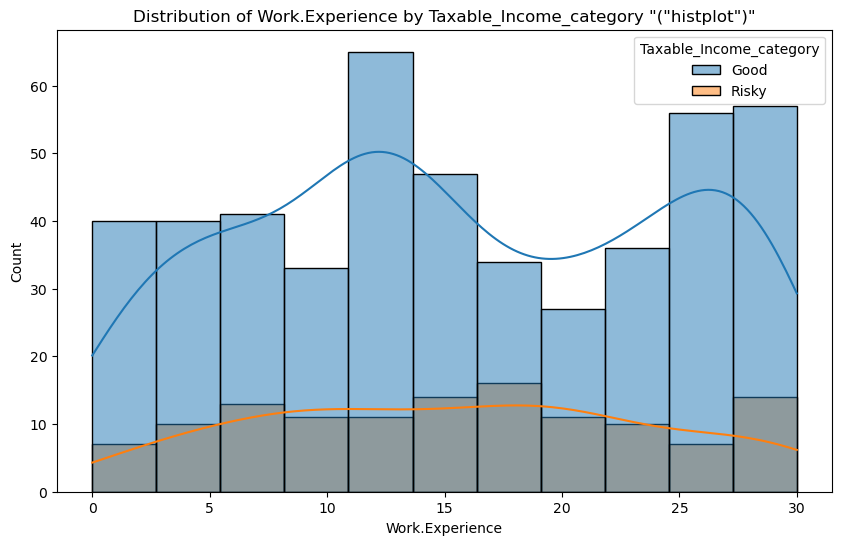

In [4]:
for feature in temp_numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data, x=feature, hue='Taxable_Income_category', kde=True)
    plt.title(f'Distribution of {feature} by Taxable_Income_category "("histplot")"')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

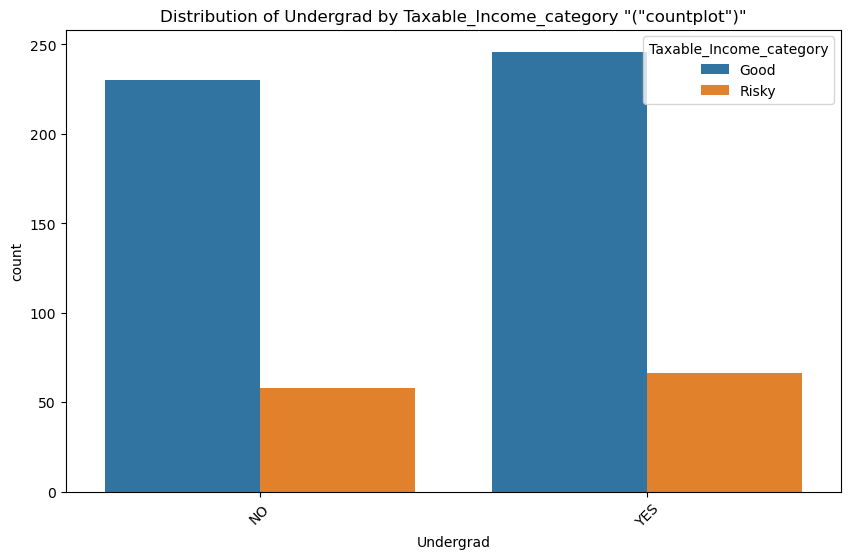

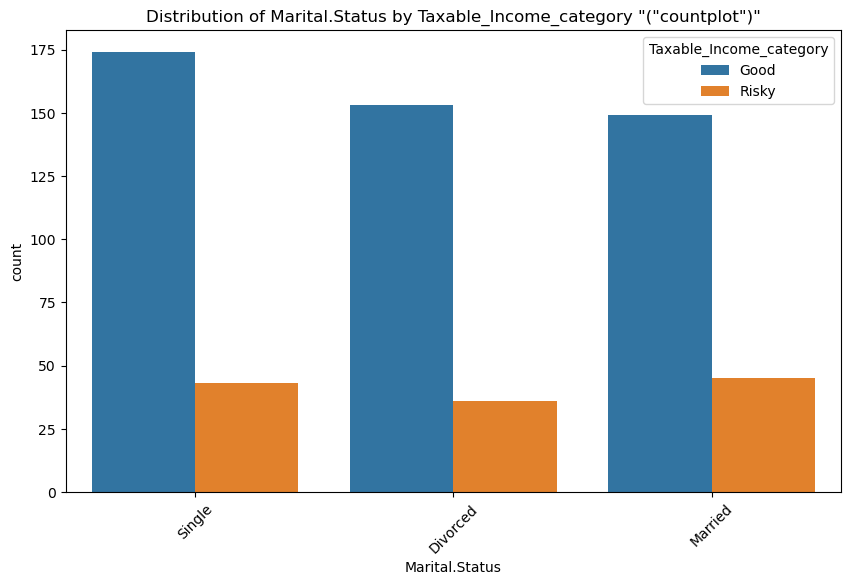

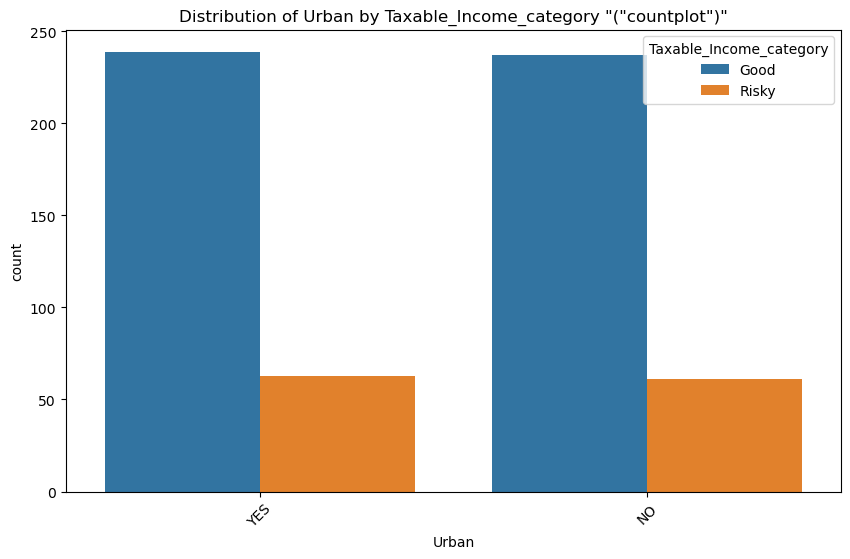

In [5]:
# Count Plots
for feature in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, hue='Taxable_Income_category', data=data)
    plt.title(f'Distribution of {feature} by Taxable_Income_category "("countplot")"')
    plt.xticks(rotation=45)
    plt.show()

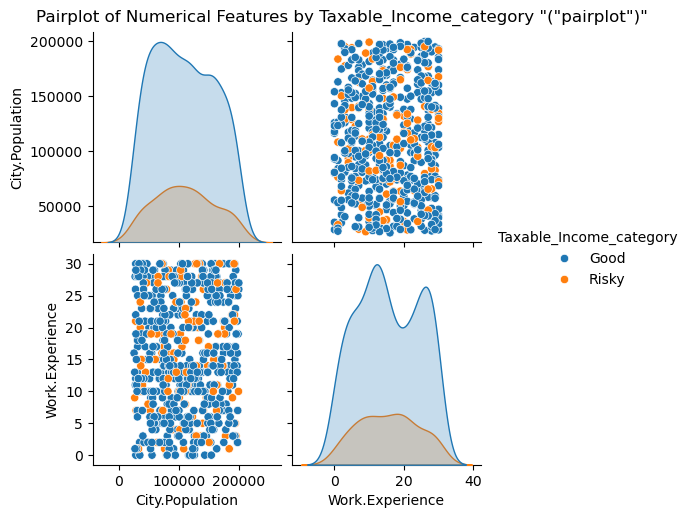

In [6]:
# Pairplot
sns.pairplot(temp_data, hue='Taxable_Income_category', diag_kind='kde')
plt.suptitle('Pairplot of Numerical Features by Taxable_Income_category "("pairplot")"', y=1.02)
plt.show()

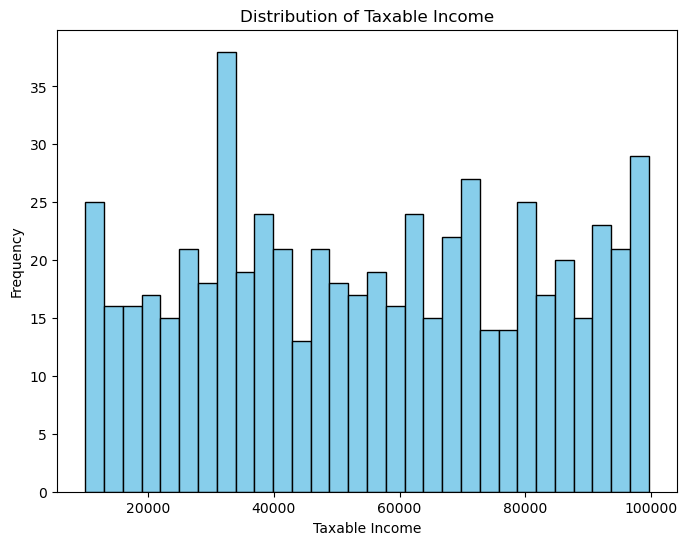

In [7]:
# Visualize the distribution of 'Taxable.Income'
plt.figure(figsize=(8, 6))
data['Taxable.Income'].plot(kind='hist', bins=30, edgecolor='black', color='skyblue')
plt.title('Distribution of Taxable Income')
plt.xlabel('Taxable Income')
plt.ylabel('Frequency')
plt.show()

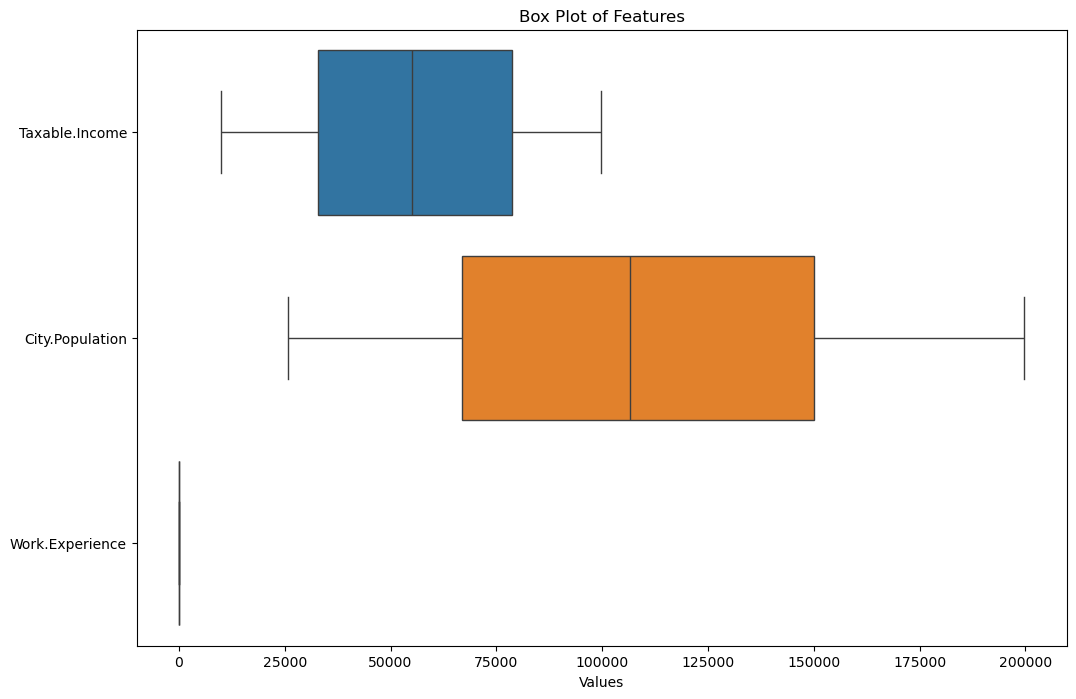

In [8]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=data, orient="h")
plt.title('Box Plot of Features')
plt.xlabel('Values')
plt.show()

In [9]:
def remove_outliers_iqr(df, features):
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df

# Remove outliers from combined_data
data = remove_outliers_iqr(data, numerical_features)

In [10]:
# Preprocess the data

# Encode categorical variables
label_encoder = LabelEncoder()
data['Undergrad'] = label_encoder.fit_transform(data['Undergrad'])
data['Marital.Status'] = label_encoder.fit_transform(data['Marital.Status'])
data['Urban'] = label_encoder.fit_transform(data['Urban'])

In [11]:
# Define features (X) and target variable (y)
X = data.drop(['Taxable.Income', 'Taxable_Income_category'], axis=1)
y = data['Taxable.Income'].apply(lambda x: 'Risky' if x <= 30000 else 'Good')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
# Oversampling with SMOTE
#smote = SMOTE(random_state=42)

#X_train, y_train = smote.fit_resample(X_train, y_train)

# Undersampling with RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

#X_test, y_test = smote.fit_resample(X_test, y_test)

In [13]:
dt_classifier = DecisionTreeClassifier(random_state=42)

# Define the grid of hyperparameters to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

model = grid_search.best_estimator_

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}


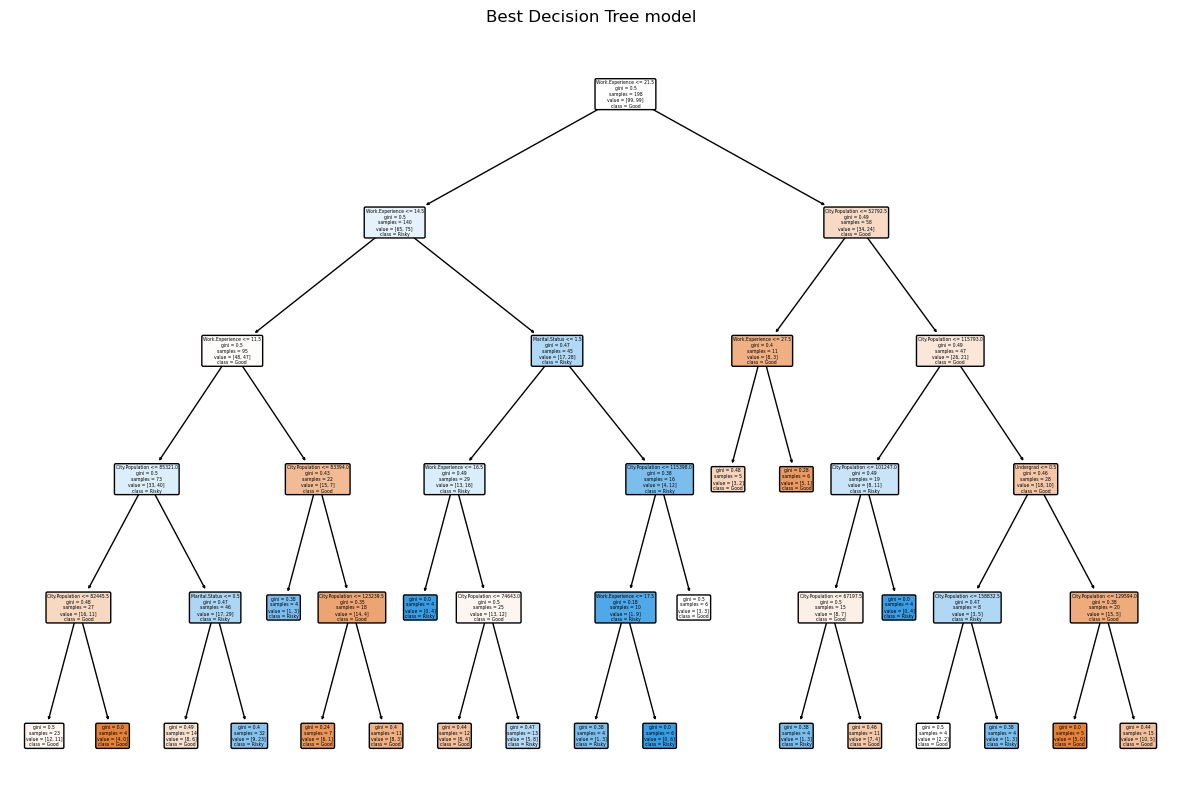

Accuracy = 0.6000

Classification Report:
              precision    recall  f1-score   support

        Good       0.85      0.60      0.70        95
       Risky       0.28      0.60      0.38        25

    accuracy                           0.60       120
   macro avg       0.57      0.60      0.54       120
weighted avg       0.73      0.60      0.64       120




In [14]:
# visualize the decision tree
plt.figure(figsize=(15, 10))
plot_tree(model, filled=True, feature_names=X.columns.tolist(), class_names=model.classes_.tolist(), rounded=True, precision=2)
plt.title("Best Decision Tree model")
plt.show()

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
classification_rep = classification_report(y_test, predictions)

print(f"Accuracy = {accuracy:.4f}")
print()
print(f"Classification Report:\n{classification_rep}\n")

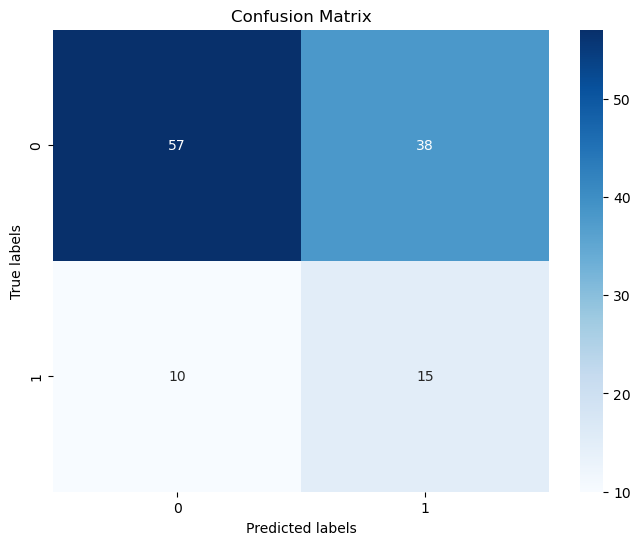

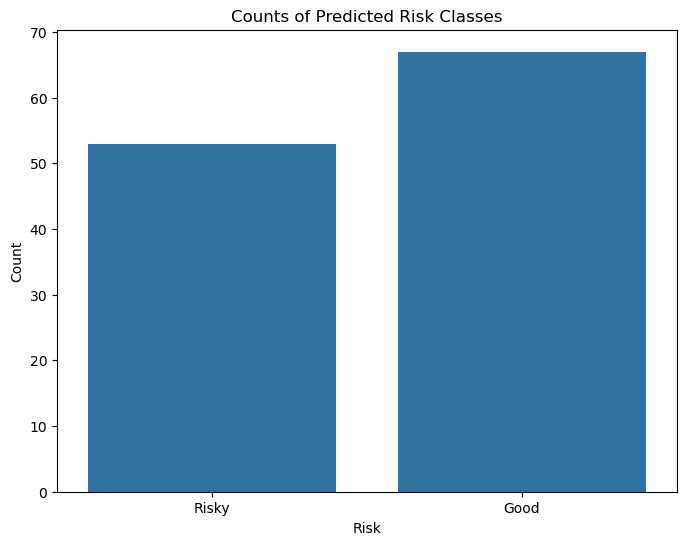

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Model Evaluation
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Prediction Analysis
# Counts of Predicted Sales Classes
X_test['Predicted_Sales'] = predictions

plt.figure(figsize=(8, 6))
sns.countplot(x='Predicted_Sales', data=X_test)
plt.title('Counts of Predicted Risk Classes')
plt.xlabel('Risk')
plt.ylabel('Count')
plt.show()